In [1]:
import sys
sys.path.append('../')
from smc.smc_sampler import LikelihoodTemperedSMC
import torch
import torch.distributions as D
from torch.func import vmap
import math
import matplotlib.pyplot as plt

## A Simple Gaussian-Gaussian Example

We consider the problem of learning the posterior of a model with a Gaussian prior and likelihood. Suppose

$$
z \sim \mathcal{N}(0, 5^2)
$$
and then 
$$
x \mid z \sim \mathcal{N}(z, 1^2).
$$

For this problem, the exact posterior is known to 
$$
z \mid x \sim \mathcal{N}(\frac{25}{26}x, \frac{25}{26}).
$$

The `smc_sampler` package requires users to specify three main functions:
- `log_prior` a function returning the log prior density (operating on batches of particles $z$).
- `log_target` a function returning the (batch of) log likelihoods of the data $x$ given a batch of particles $z$.
- `proposal` a function that, given a batch of current particles, proposes a new batch. Our implementation requires the proposal kernel to leave the current stage target distribution invariant, and we accomplish this with Metropolis-Hastings adjustments.

Suppose that from the model above we draw $x = 6.2$.

In [2]:
true_x = torch.tensor(6.2)

def log_target(z_batch, true_x):
    '''
    Given a 'z_batch' object of size K x ...,
    where K is the number of particles, ... the latent dimension.
    
    Returns log p(x | z), for likelihood tempered SMC, of shape (K,1).
    '''
    distr = D.Normal(z_batch, 1.)
    log_probs = distr.log_prob(true_x) # shape N x len(true_x)
    return log_probs

def log_prior(z_batch):
    '''
    Given a 'z_batch' object of size K x ...,
    Returns log p(z), for likelihood tempered SMC.
    '''
    lps = D.Normal(0., 5.).log_prob(z_batch) # for our problem, N x len(true_x)
    return lps

Of the three user-defined functions, `proposal` is the most complex. We consider two different proposals in this notebook, a Metropolis-Hastings Random Walk with symmetric Gaussian proposals, and also a Metropolis-Adjusted Langevin proposal that follows the gradient of the target function to propose new particles (adding Gaussian noise after following the gradient for a small step).

In [3]:
def gradient_proposal(z_batch, true_x):
    '''
    Given a batch of particles z_batch and the true_x,
    computes the per-particle gradient of $p(z,x)$ with 
    respect to $z$, evaluated at each of the $K$ particles.

    Unfortunately have to hard code log-density as D.Normal.log_prob
    doesn't work within torch.grad + vmap currently. 
    '''
    z_batch = z_batch.detach()
    gradder = torch.func.grad(lambda z, true_x: -0.5*math.log(2*math.pi)- \
                              math.log(5.)-0.5*torch.square(z/5.)- \
                              0.5*math.log(2*math.pi)-math.log(1.)-0.5*torch.square((z-true_x)/1.))
    mapped = vmap(gradder, (0, None))
    grads_per_particle = mapped(z_batch, true_x)
    return grads_per_particle

def mh_step_gradient(z_batch, true_x, curr_target, **kwargs):
    '''
    Proposal kernel using Metropolis-adjusted Langevin dynamics.
    Compute gradients using above helper, use to propose.
    '''
    # Propose new particles
    eta = 0.01
    grads_per_particle = gradient_proposal(z_batch, true_x)
    means = z_batch + eta*grads_per_particle
    sds = math.sqrt(2*eta)
    proposed_particles = D.Normal(means, sds).sample()

    # Perform Metropolis adjustment using curr_target (leave invariant)
    lps_curr = curr_target(z_batch)
    lps_new = curr_target(proposed_particles)
    lp_ratios = lps_new - lps_curr
    lp_ratios = torch.exp(lp_ratios).clamp(min=0., max=1.)
    flips = D.Bernoulli(lp_ratios).sample()
    indices_old = torch.arange(len(flips))[flips.reshape(-1) == 0]
    indices_new = torch.arange(len(flips))[flips.reshape(-1) == 1]
    new = torch.empty(proposed_particles.shape)
    new[indices_new] = proposed_particles[indices_new]
    new[indices_old] = z_batch[indices_old]
    return new

def mh_step(z_batch, true_x, curr_target, **kwargs):
    '''
    Metropolis-Hastings random walk kernel.
    '''
    noise = 0.2
    proposed_particles = D.Normal(z_batch, noise).sample()
    lps_curr = curr_target(z_batch)
    lps_new = curr_target(proposed_particles)
    lp_ratios = lps_new - lps_curr
    lp_ratios = torch.exp(lp_ratios).clamp(min=0., max=1.)
    flips = D.Bernoulli(lp_ratios).sample()
    indices_old = torch.arange(len(flips))[flips == 0]
    indices_new = torch.arange(len(flips))[flips == 1]
    new = torch.empty(proposed_particles.shape)
    new[indices_new] = proposed_particles[indices_new]
    new[indices_old] = z_batch[indices_old]
    return new

Having defined these helper functions, we can now define two different proposal functions to plug into the sampler.

In [4]:
def proposal(z_batch, true_x, curr_target, **kwargs):
    '''
    Given a 'z_batch' K x ...,
    Return a mutated batch of size K x ...
    '''
    new = z_batch
    for _ in range(100):
        new = mh_step(new, true_x, curr_target, **kwargs)
    return new

def proposal_mala(z_batch, true_x, curr_target, **kwargs):
    '''
    Given a 'z_batch' K x ...,
    Return a mutated batch of size K x ...
    '''
    new = z_batch
    for _ in range(100):
        new = mh_step_gradient(new, true_x, curr_target, **kwargs)
    return new

Now we can run the sampler to get the approximations to the posterior by likelihood-tempered SMC. The `LikelihoodTemperedSMC` object prints out the adaptive temperatures as they are selected. The user picks $K$, the number of particles, and supplies the three functions `log_prior`, `log_target`, and `proposal` along with an initial set of particles, weights, and log-weights. 

Because the first target at time $t=0$ is the prior, and all particles are drawn from the prior, they can be assigned equal weight analytically.

In [5]:
'''
Now we run the SMC sampler to get the posterior.
'''
n_particles = 100000
particles = D.Normal(0., 5.).sample((n_particles, ))
particles = particles.unsqueeze(1)
init_weights = torch.ones(n_particles)/n_particles
init_log_weights = torch.zeros((n_particles, 1))
final_target_fcn = lambda z: log_prior(z)+log_target(z, true_x)
SMC_mhrw = LikelihoodTemperedSMC(particles, init_weights, init_log_weights, final_target_fcn, D.Normal(0., 10.), log_prior, log_target, proposal, max_mc_steps=100, context=true_x, kwargs={})
SMC_mhrw.run()

0.08028579130797794
0.18699465692037984


/home/declan/current/likelihood_tempered_smc/examples/../smc/smc_sampler.py:138: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  solutions = fsolve(func=func, x0=x0, maxfev=1000)


0.29370352253278176
0.40041238814518365
0.5071212537575855
0.6138301193699874
0.7205389849823893
0.8272478505947912
1.0


In [6]:
n_particles = 100000
particles = D.Normal(0., 5.).sample((n_particles, ))
particles = particles.unsqueeze(1)
init_weights = torch.ones(n_particles)/n_particles
init_log_weights = torch.zeros((n_particles, 1))
final_target_fcn = lambda z: log_prior(z)+log_target(z, true_x)
SMC_mala = LikelihoodTemperedSMC(particles, init_weights, init_log_weights, final_target_fcn, D.Normal(0., 10.), log_prior, log_target, proposal_mala, max_mc_steps=100, context=true_x, kwargs={})
SMC_mala.run()

0.08022179082196818
0.7465482242418491
1.0


Let's examine the SMC posteriors and the exact posteriors visually. Using the weights and particles from the final iteration of SMC, we sample 10,000 particles and compute a histogram. Let's look at the results of the MHRW proposal first.

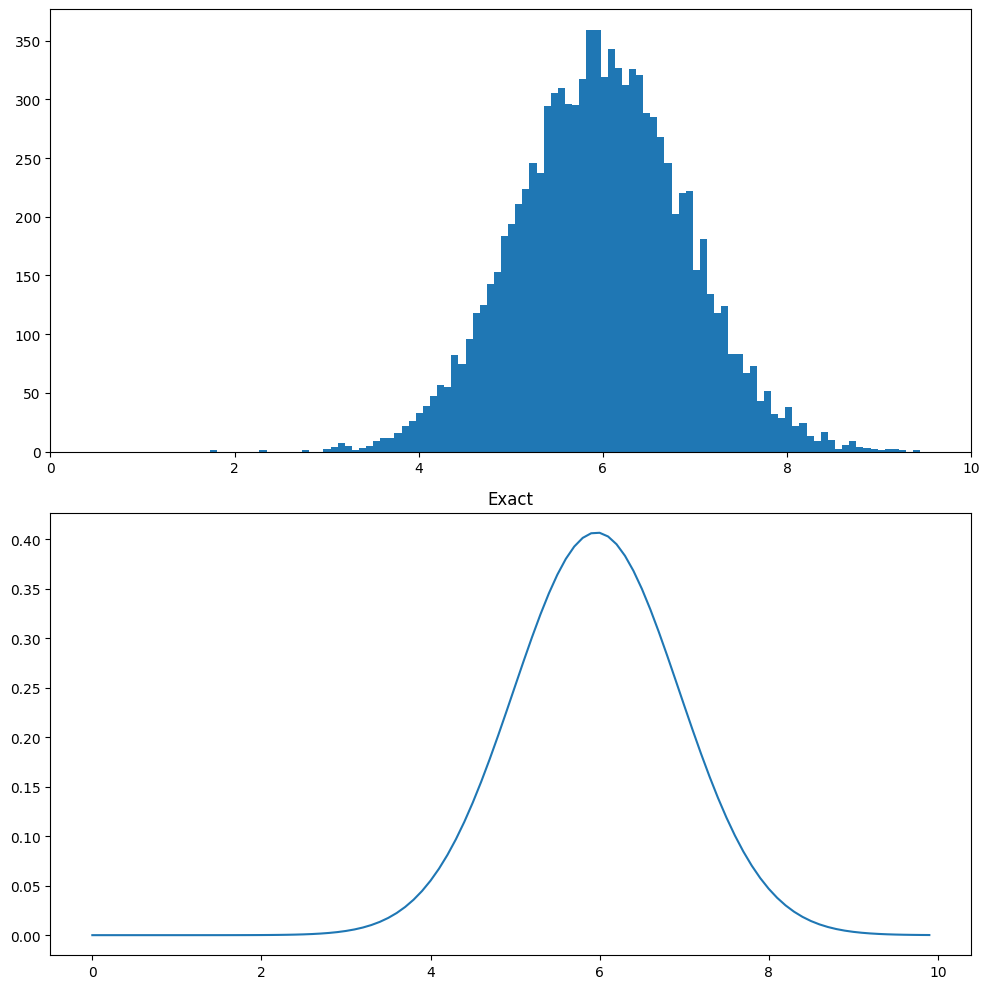

In [7]:
'''
We now examine the SMC and exact posteriors visually.
'''
samples = SMC_mhrw.sampler.current_ed.sample(10000)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
# yo = sns.kdeplot(samples[:,-1].view(-1).numpy(), bw_adjust=.2, ax=ax[0])
# yo.set(xlabel='$z_1$', title='SMC p(z | x)')
ax[0].hist(samples[:,-1].view(-1).numpy(), bins=100)
ax[0].set_xlim(0., 10.)

multiplier = 25/26

lps_exact = D.Normal(multiplier*true_x, math.sqrt(multiplier)).log_prob(torch.arange(0., 10., .1))
ax[1].plot(torch.arange(0., 10., .1), lps_exact.exp())
ax[1].set_title('Exact')
plt.tight_layout()

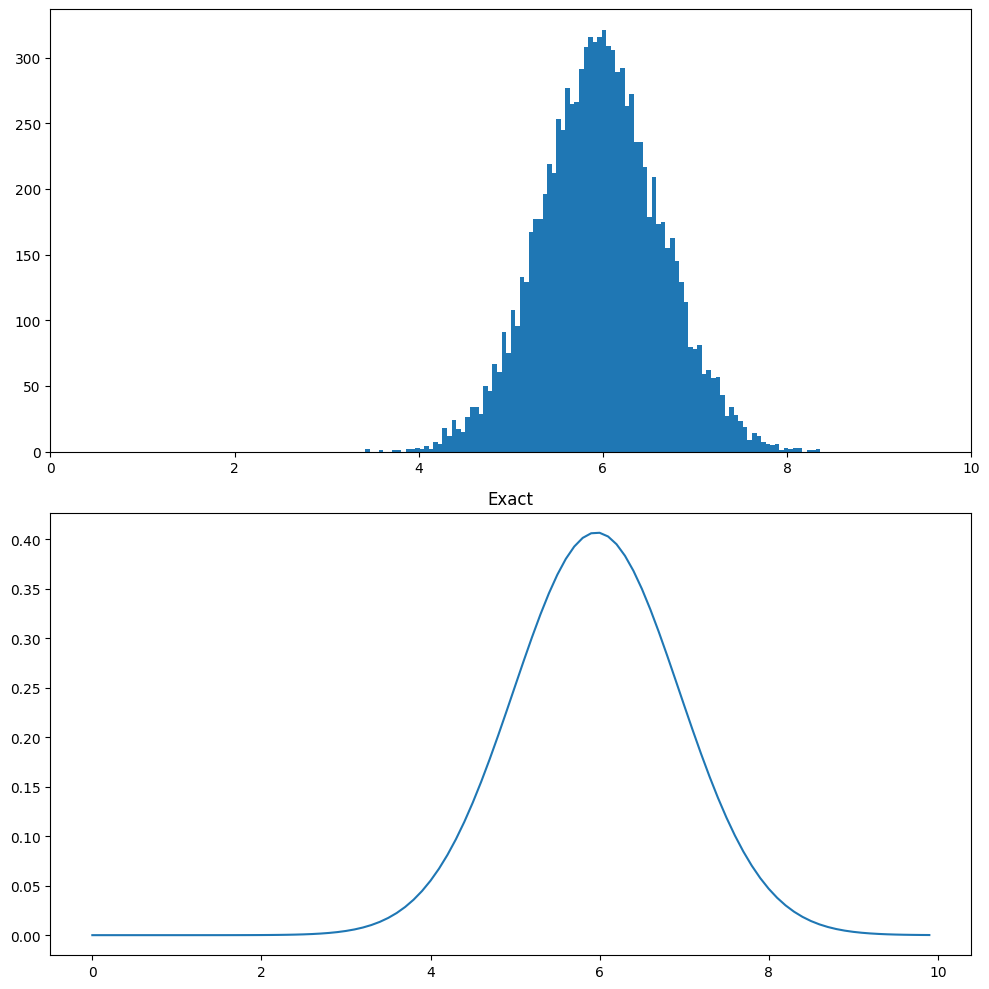

In [8]:
'''
We now examine the SMC and exact posteriors visually.
'''
samples = SMC_mala.sampler.current_ed.sample(10000)
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,10))
# yo = sns.kdeplot(samples[:,-1].view(-1).numpy(), bw_adjust=.2, ax=ax[0])
# yo.set(xlabel='$z_1$', title='SMC p(z | x)')
ax[0].hist(samples[:,-1].view(-1).numpy(), bins=100)
ax[0].set_xlim(0., 10.)

multiplier = 25/26

lps_exact = D.Normal(multiplier*true_x, math.sqrt(multiplier)).log_prob(torch.arange(0., 10., .1))
ax[1].plot(torch.arange(0., 10., .1), lps_exact.exp())
ax[1].set_title('Exact')
plt.tight_layout()

Overall, the tails look a bit lighter. The results could change if we tune `eta` or `noise` for each of the two proposal kernels, and depending on the problem (or in high dimensions) the results might depend significantly on these hyperparameters. For example, the MALA version only looked at three temperatures, a rather coarse temperature schedule. This suggests maybe we should choose a smaller `eta` for this kernel to allow for more mutations.